In this notebook two deep learning methods are tested for air pollution prediction. **LSTM** and **CNN**. 

Univariate and Multivariate models are created to compare how a larger number of features affects the accuracy of the forecasts.


In the univariate models only values from previous days are used to make a prediction, whereas, in the multivariate models, weather forecast features are also taken in account for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Data for years 2015-2018 are stored in a single file for each year
data2015 = pd.read_csv("mixed_cities/2015H1.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2016 = pd.read_csv("mixed_cities/2016H1.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2017 = pd.read_csv("mixed_cities/2017H1.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2018 = pd.read_csv("mixed_cities/2018H1.csv", skiprows=4, parse_dates=["Date"], index_col="Date")

#Data for year 2019 are stored in 4 different files, collecting them all
data2019Q1 = pd.read_csv("mixed_cities/2019Q1.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2019Q2 = pd.read_csv("mixed_cities/2019Q2.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2019Q3 = pd.read_csv("mixed_cities/2019Q3.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2019Q4 = pd.read_csv("mixed_cities/2019Q4.csv", skiprows=4, parse_dates=["Date"], index_col="Date")

#Data for year 2020 are stored in 4 different files, collecting them all
data2020Q1 = pd.read_csv("mixed_cities/2020Q1.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2020Q2 = pd.read_csv("mixed_cities/2020Q2.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2020Q3 = pd.read_csv("mixed_cities/2020Q3.csv", skiprows=4, parse_dates=["Date"], index_col="Date")
data2020Q4 = pd.read_csv("mixed_cities/2020Q4.csv", skiprows=4, parse_dates=["Date"], index_col="Date")

#Data for year 2021 are stored in 4 different files, collecting them all
data2021Q1 = pd.read_csv("mixed_cities/2021Q1.csv", parse_dates=["Date"], index_col="Date")
data2021Q2 = pd.read_csv("mixed_cities/2021Q2.csv", parse_dates=["Date"], index_col="Date")
data2021Q3 = pd.read_csv("mixed_cities/2021Q3.csv", parse_dates=["Date"], index_col="Date")
data2021Q4 = pd.read_csv("mixed_cities/2021Q4.csv", parse_dates=["Date"], index_col="Date")

#Data for year 2022
data2022 = pd.read_csv("mixed_cities/2022.csv", parse_dates=["Date"], index_col="Date")

In [3]:
#concatenate the different dataframes collected for years 2019-2021 and concatenate them into one dataframe per year
all2019 = [data2019Q1, data2019Q2, data2019Q3, data2019Q4]
all2020 = [data2020Q1, data2020Q2, data2020Q3, data2020Q4]
all2021 = [data2021Q1, data2021Q2, data2021Q3, data2021Q4]

data2019 = pd.concat(all2019)
data2020 = pd.concat(all2020)
data2021 = pd.concat(all2021)

In [4]:
#The column 'Specie' holds the pollutants and weather conditions that affect air pollution
#To manage each pollutant as a separate time series, I made every unique value in 'Specie' into a separate column
#If there are multiple rows of the same [date, country, city] and the same pollutant I store the mean of the values

cleaned2015 = data2015.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()
cleaned2016 = data2016.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()
cleaned2017 = data2017.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()
cleaned2018 = data2018.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()
cleaned2019 = data2019.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()
cleaned2020 = data2020.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()
cleaned2021 = data2021.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()
cleaned2022 = data2022.pivot_table(index=['Date', 'Country', 'City'], 
                     columns='Specie', 
                     values='median', 
                     fill_value='',
                     aggfunc=np.mean).rename_axis(None, axis=1).reset_index()

In [5]:
#'Date' should be the index of the time series
cleaned2015 = cleaned2015.set_index('Date')
cleaned2016 = cleaned2016.set_index('Date')
cleaned2017 = cleaned2017.set_index('Date')
cleaned2018 = cleaned2018.set_index('Date')
cleaned2019 = cleaned2019.set_index('Date')
cleaned2020 = cleaned2020.set_index('Date')
cleaned2021 = cleaned2021.set_index('Date')
cleaned2022 = cleaned2022.set_index('Date')

In [6]:
def split_ts_by_window(time_series, n_steps):
    window, output = list(), list()
    
    #UNIVARIATE MODEL
    if(isinstance(time_series, pd.Series)):
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series)-1:
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE WHICH IS THE OBSERVATION AFTER THE END OF THE WINDOW
            input_features, output_pollutant = time_series[i:window_limit], time_series[window_limit]

            window.append(input_features)
            output.append(output_pollutant)
    
    #MULTIVARIATE MODEL
    else:
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series):
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE COMING FROM 'n_steps' WINDOW USED

            #THE OUTPUT VALUES ARE THOSE OF THE FIRST COLUMN (POLLUTANT COLLUMN)
            input_features, output_pollutant = time_series[i:window_limit,:1], time_series[window_limit-1,0]
            
            window.append(input_features)
            output.append(output_pollutant)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [7]:
#GATHER ATHENS DATA FROM ALL AVAILABLE YEARS
Athens_Data = pd.concat([cleaned2015[cleaned2015['City']=='Athens'], cleaned2016[cleaned2016['City']=='Athens'],
                     cleaned2017[cleaned2017['City']=='Athens'], cleaned2018[cleaned2018['City']=='Athens'], 
                     cleaned2019[cleaned2019['City']=='Athens'], cleaned2020[cleaned2020['City']=='Athens'],
                     cleaned2021[cleaned2021['City']=='Athens'], cleaned2022[cleaned2022['City']=='Athens']])

In [ ]:
#ATHENS DATA PREVIEW
Athens_Data

## Data Preparation for Univariate Models

In [8]:
#DATA PREPARATION FOR UNIVARIATE MODELS

#KEEP ONLY THE POLLUTANTS COLUMNS
cols=['pm25', 'pm10', 'no2', 'o3', 'so2']

#MAKE VALUES NUMERIC
Athens_Data_uni = Athens_Data.loc[:, Athens_Data.columns.intersection(cols)]
Athens_Data_uni = Athens_Data_uni.apply(pd.to_numeric, errors='coerce')

#FILL NAN VALUES
Athens_Data_uni = Athens_Data_uni.iloc[1: , :]

#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Athens_Data_uni = Athens_Data_uni.replace(r'^\s*$', np.nan, regex=True)
Athens_Data_uni = Athens_Data_uni.fillna(method='ffill')
Athens_Data_uni = Athens_Data_uni.fillna(method='bfill')

#REMOVE DUPLICATE VALUES
Athens_Data_uni = Athens_Data_uni[~Athens_Data_uni.index.duplicated(keep='first')]

In [ ]:
#UNIVARIATE DATA PREVIEW
Athens_Data_uni

## Data preparation for Multivariate Models

In [9]:
#DATA PREPARATION FOR MULTIVARIATE MODELS

#ALL COLUMNS
Athens_Data.columns

Index(['Country', 'City', 'aqi', 'co', 'mepaqi', 'neph', 'no2', 'o3', 'pm10',
       'pm25', 'psi', 'so2', 'uvi', 'pol', 'd', 'humidity', 'pm1', 'pressure',
       'temperature', 'wd', 'wind-speed', 'precipitation', 'wind-gust', 'dew',
       'wind gust', 'wind speed'],
      dtype='object')

In [10]:
#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Athens_Data = Athens_Data.replace(r'^\s*$', np.nan, regex=True)

#DECIDE WHICH COLUMNS TO KEEP BASED ON HOW MANY MISSING VALUES THERE ARE. IF A COLUMNS HAS A FEW MISSING VALUES,
#COMPARED TO THE LENGTH OF THE DATAFRAME, THEN KEEP IT. OTHERWISE, DROP IT.

(Athens_Data).isna().sum()

Country            0
City               0
aqi              861
co               355
mepaqi           861
neph             861
no2                8
o3                 9
pm10               7
pm25              24
psi              861
so2               21
uvi              861
pol              861
d                861
humidity          22
pm1              861
pressure          22
temperature       22
wd               861
wind-speed        88
precipitation    861
wind-gust         92
dew               56
wind gust        778
wind speed       774
dtype: int64

In [11]:
#MAKE THE REMAINING COLUMNS NUMERIC
cols=['pm25', 'pm10', 'no2', 'o3', 'so2', 'wind-speed', 'humidity', 'pressure', 
      'temperature', 'wind-gust', 'dew']

Athens_Data_multi = Athens_Data.loc[:, Athens_Data.columns.intersection(cols)]
Athens_Data_multi = Athens_Data_multi.apply(pd.to_numeric, errors='coerce')

In [12]:
(Athens_Data_multi).isna().sum()

no2             8
o3              9
pm10            7
pm25           24
so2            21
humidity       22
pressure       22
temperature    22
wind-speed     88
wind-gust      92
dew            56
dtype: int64

In [13]:
#FILL NAN VALUES WITH BACKWARD FILLING AND CHECK THAT THERE ARE NONE LEFT
Athens_Data_multi = Athens_Data_multi.iloc[1: , :]
Athens_Data_multi = Athens_Data_multi.fillna(method='bfill')

#REMOVE DUPLICATE VALUES
Athens_Data_multi = Athens_Data_multi[~Athens_Data_multi.index.duplicated(keep='first')]

(Athens_Data_multi).isna().sum()

no2            0
o3             0
pm10           0
pm25           0
so2            0
humidity       0
pressure       0
temperature    0
wind-speed     0
wind-gust      0
dew            0
dtype: int64

In [14]:
pollutants = ['o3', 'so2', 'no2', 'pm25', 'pm10']
weather_conds = ['wind-speed', 'humidity', 'pressure', 'temperature', 'wind-gust', 'dew']

#CREATE FIVE DIFFERENT DATASETS, EACH CONTAINS ONE OF THE POLLUTANTS AND ALL THE WEATHER CONDITIONS
Athens_o3 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['wind-speed', 'humidity', 'pressure', 'temperature', 'wind-gust', 'dew', 'o3'])]
Athens_so2 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['wind-speed', 'humidity', 'pressure', 'temperature', 'wind-gust', 'dew', 'so2'])]
Athens_no2 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['wind-speed', 'humidity', 'pressure', 'temperature', 'wind-gust', 'dew', 'no2'])]
Athens_pm25 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['wind-speed', 'humidity', 'pressure', 'temperature', 'wind-gust', 'dew', 'pm25'])]
Athens_pm10 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['wind-speed', 'humidity', 'pressure', 'temperature', 'wind-gust', 'dew', 'pm10'])]

datasets = [Athens_o3, Athens_no2, Athens_so2, Athens_pm10, Athens_pm25]

In [ ]:
#MULTIVARIATE DATA PREVIEW
Athens_o3

# UNIVARIATE CNN

Univariate CNN RMSE for Athens[no2]:4.684220247467259


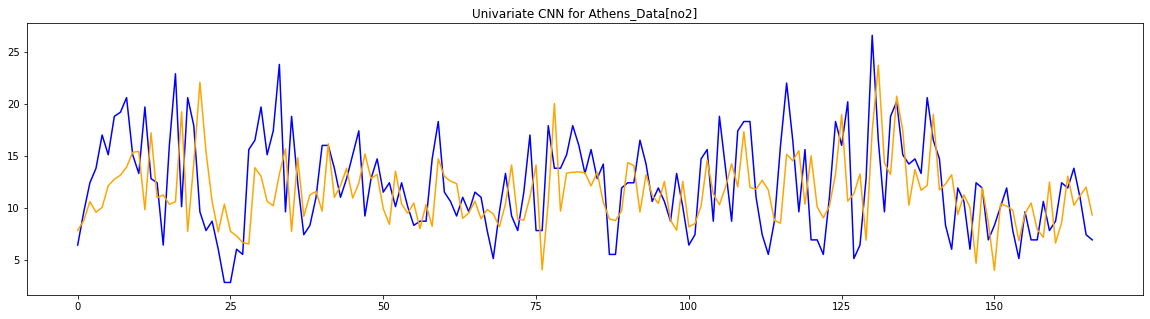

Univariate CNN RMSE for Athens[o3]:5.772257972160285


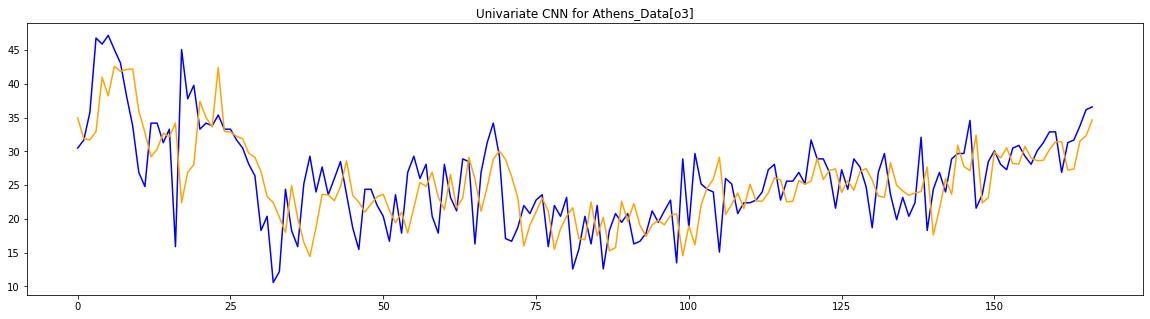

Univariate CNN RMSE for Athens[pm10]:7.619041741459714


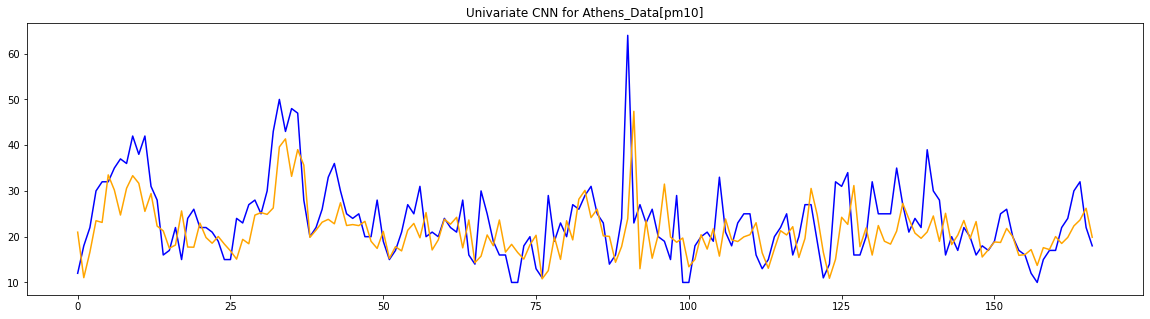

Univariate CNN RMSE for Athens[pm25]:11.799162262743023


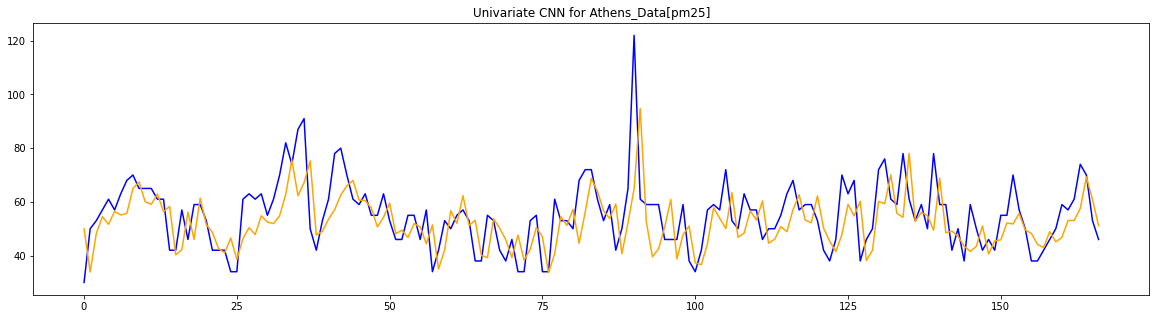

Univariate CNN RMSE for Athens[so2]:1.9144137313267429


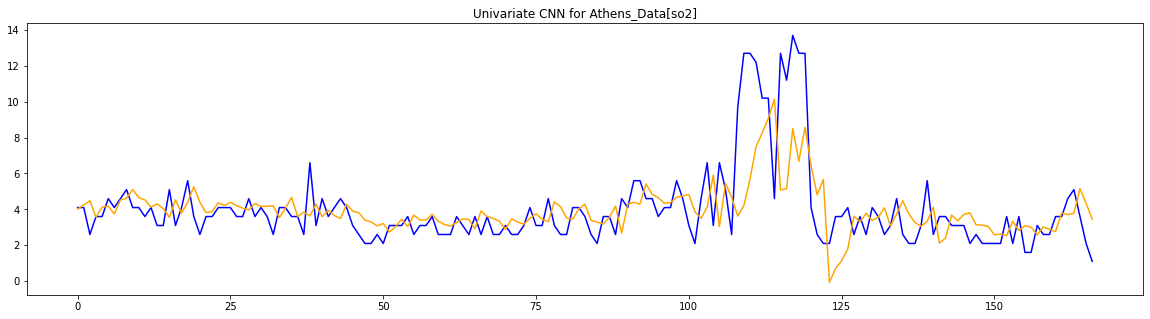

In [15]:
n_steps = 7
n_features = 1

#CNN UNIVARIATE MODEL
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

for col in Athens_Data_uni.columns:
    
    #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
    window, output = split_ts_by_window(Athens_Data_uni[col], n_steps)
    
    #RESHAPE INPUT TO PASS IT TO THE MODEL
    window = window.reshape((window.shape[0], window.shape[1], n_features))
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
    print("Univariate CNN RMSE for Athens[" + str(col) + "]:" + str(rmse_ucnn))
    
    title = "Univariate CNN for Athens_Data" + "[" + col +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# MULTIVARIATE CNN

Multivariate CNN RMSE for Athens[o3]:1.258195048853747


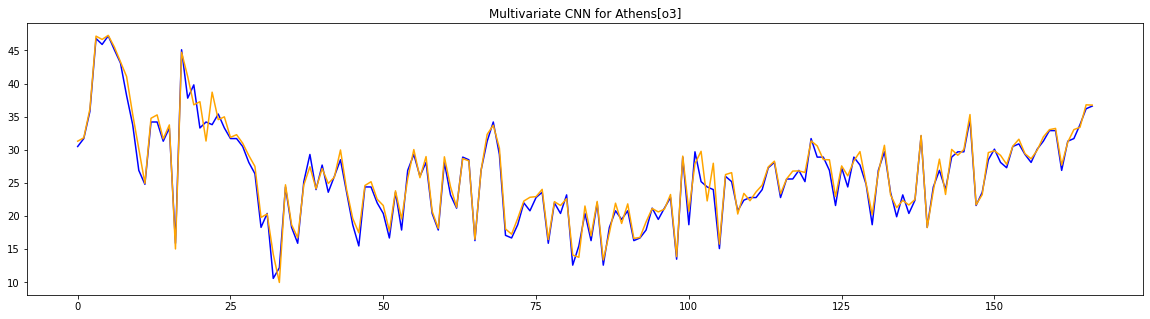

Multivariate CNN RMSE for Athens[no2]:0.539283789948862


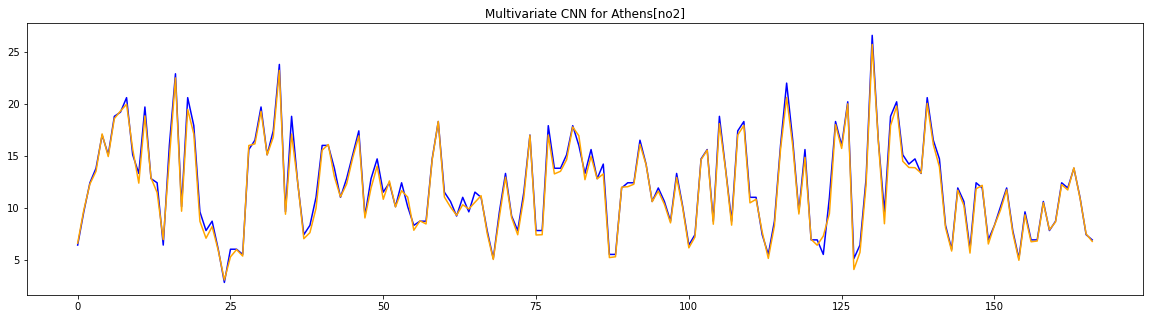

Multivariate CNN RMSE for Athens[so2]:0.330957595405987


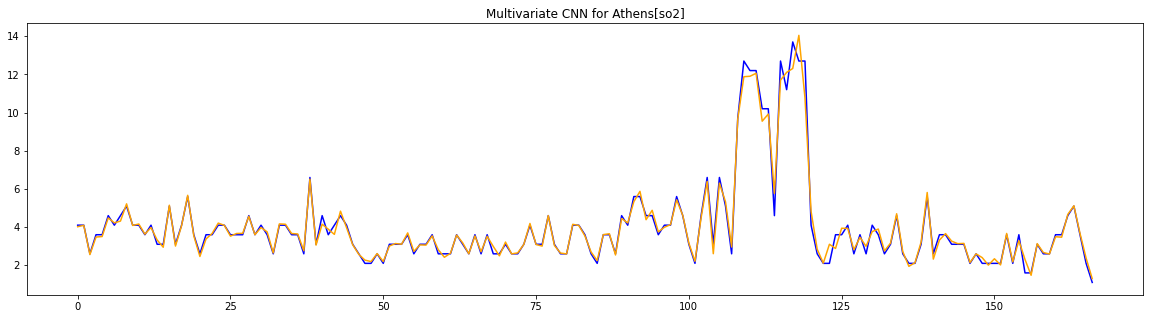

Multivariate CNN RMSE for Athens[pm10]:1.1153388567348994


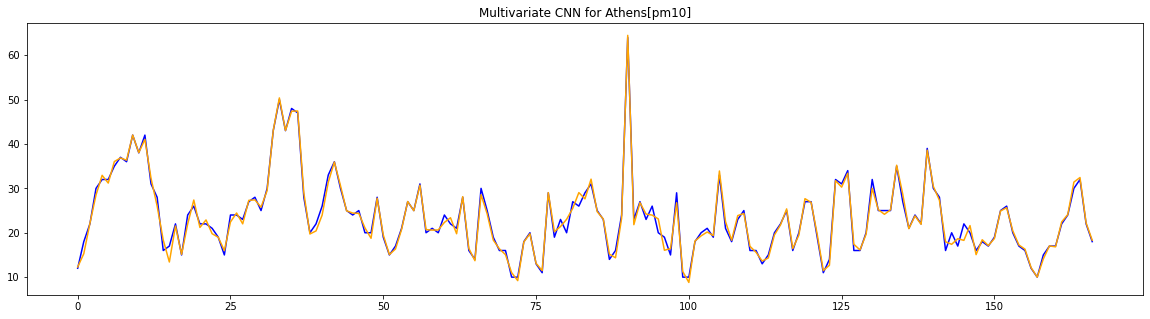

Multivariate CNN RMSE for Athens[pm25]:2.200488088390491


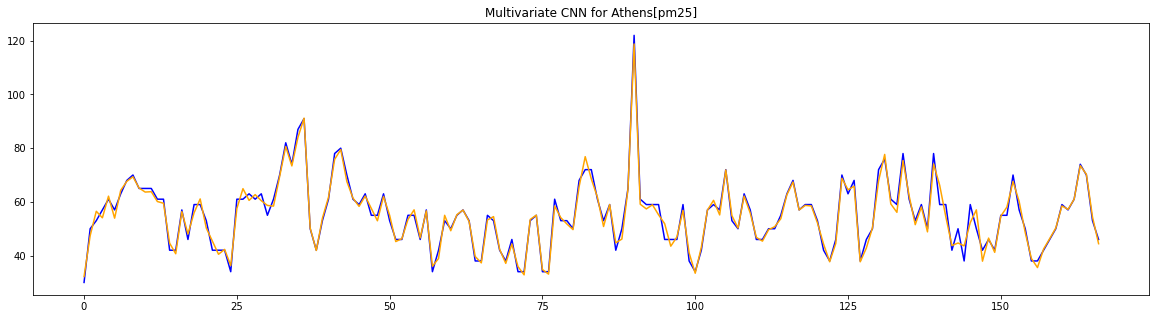

In [16]:
n_steps=7
for data in datasets:
    
    #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
    window, output = split_ts_by_window(np.asarray(data), n_steps)
      
    n_features= window.shape[2]
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #MULTIVARIATE CNN MODEL
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #FIT TRAIN DATA TO THE MODEL
    model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
    print("Multivariate CNN RMSE for Athens[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
    
    title = "Multivariate CNN for Athens[" + str(data.columns[0]) + "]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# UNIVARIATE LSTM

Univariate LSTM RMSE for Athens[no2]:4.241833863526109


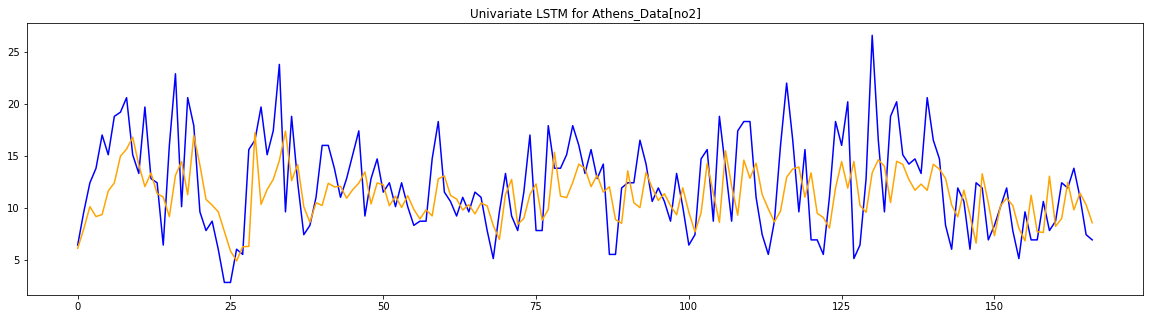

Univariate LSTM RMSE for Athens[o3]:5.69243935533871


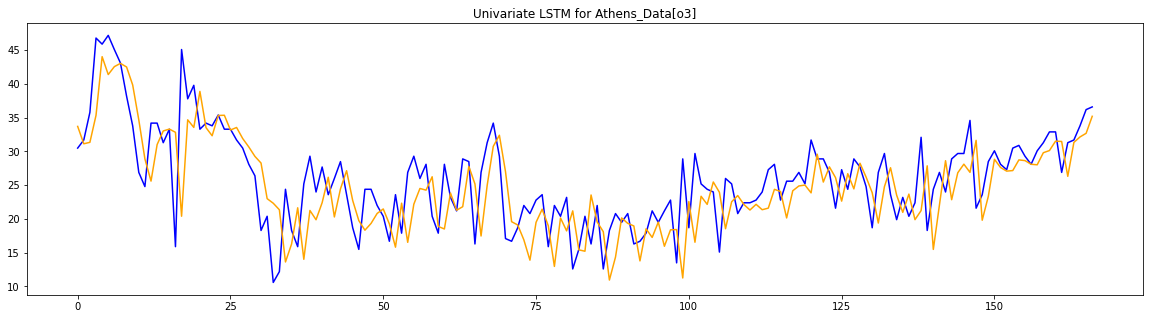

Univariate LSTM RMSE for Athens[pm10]:7.215596092169519


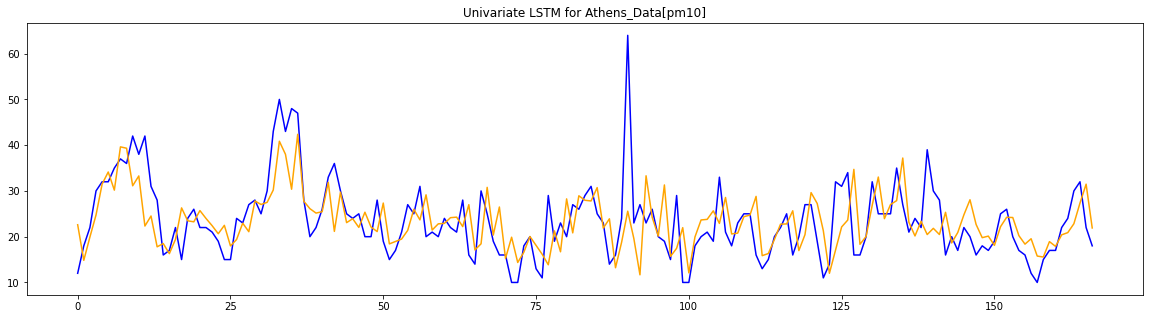

Univariate LSTM RMSE for Athens[pm25]:11.795174623937523


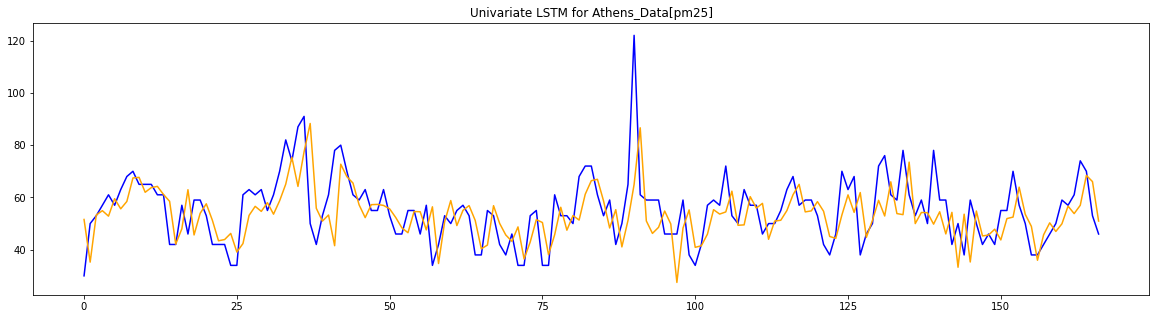

Univariate LSTM RMSE for Athens[so2]:1.731816647337095


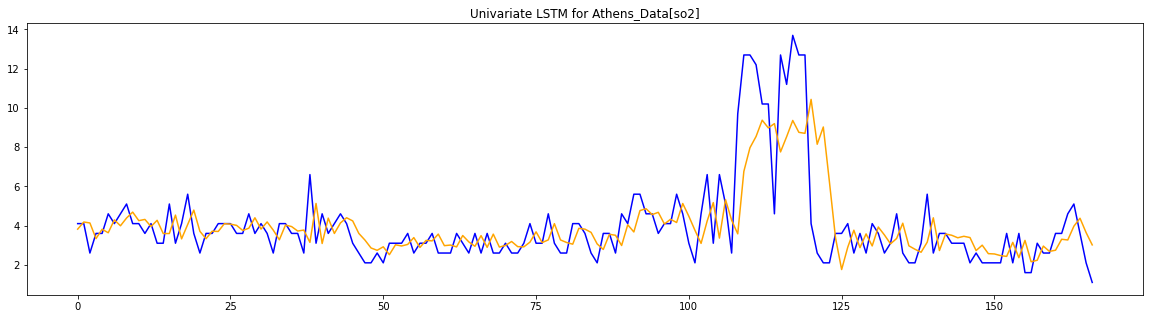

In [17]:
n_steps=7

for col in Athens_Data_uni.columns:
    window, output = split_ts_by_window(Athens_Data_uni[col], n_steps)
    
    #RESHAPE INPUT TO PASS IT TO THE MODEL
    window = window.reshape((window.shape[0], window.shape[1], 1))
    
    #UNIVARIATE LSTM MODEL
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
    lstm_model.add(Dense(30,activation='relu'))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1,activation='relu'))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, 1))
    
    #PREDICT THE TEST PORTION
    pred = lstm_model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_ulstm = math.sqrt(mean_squared_error(test_y, pred))
    print("Univariate LSTM RMSE for Athens[" + str(col) + "]:" + str(rmse_ulstm))
    
    title = "Univariate LSTM for Athens_Data" + "[" + col +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# MULTIVARIATE LSTM

Multivariate LSTM RMSE for Athens[o3]:0.37675360108232187


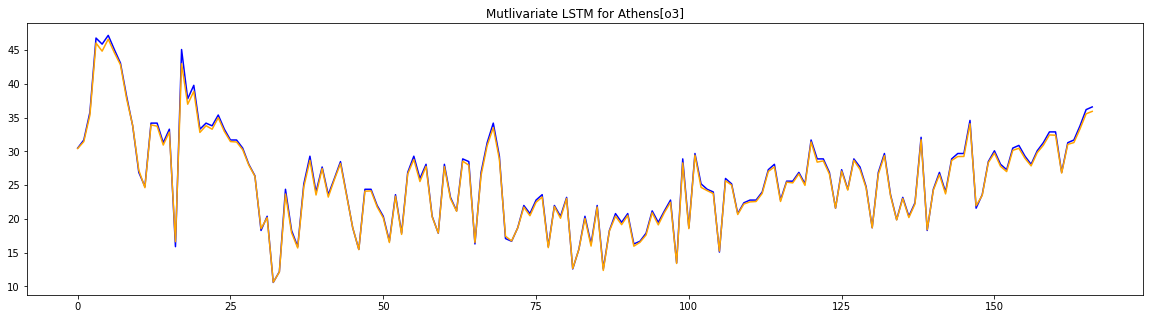

Multivariate LSTM RMSE for Athens[no2]:0.20458819586697907


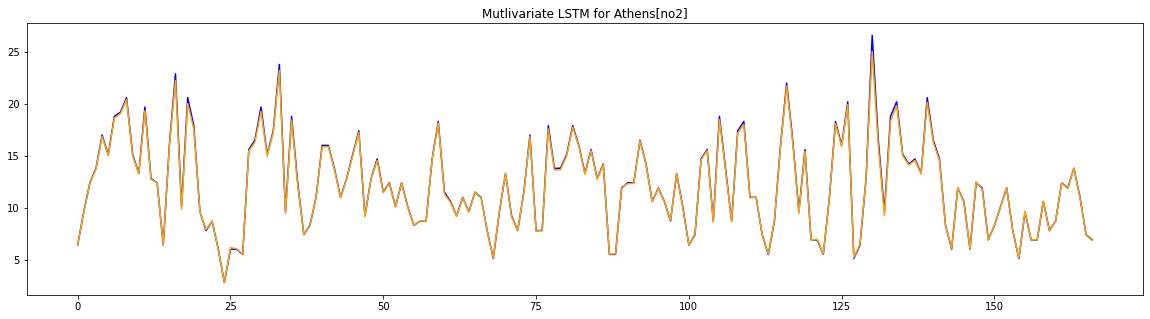

Multivariate LSTM RMSE for Athens[so2]:0.2907915853091307


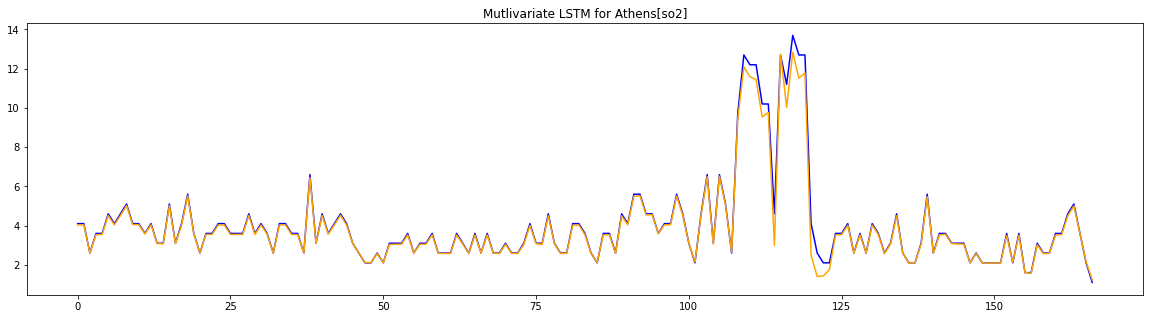

Multivariate LSTM RMSE for Athens[pm10]:0.7178685131812803


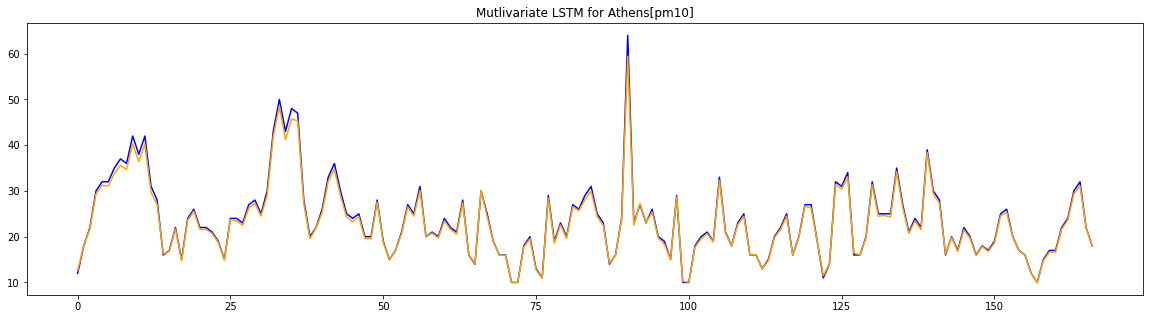

Multivariate LSTM RMSE for Athens[pm25]:2.3630759410109143


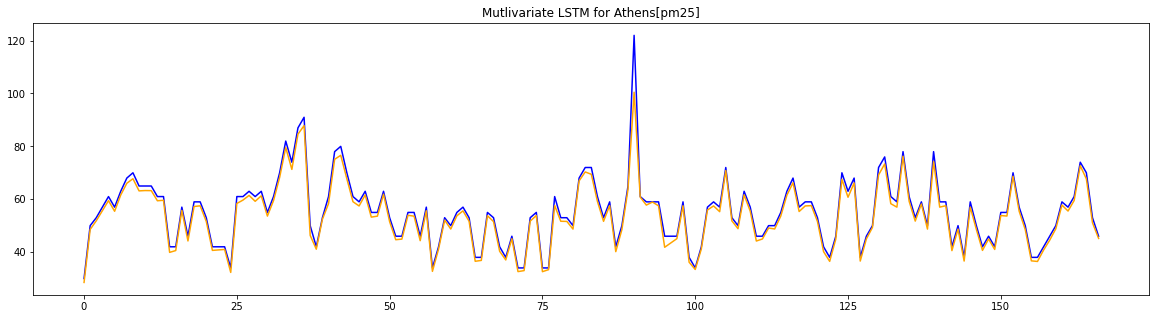

In [18]:
n_steps=7

for data in datasets:
    window, output = split_ts_by_window(np.asarray(data), n_steps)
    
    n_features = window.shape[2]
    
    #MULTIVARIATE LSTM MODEL
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(n_steps, n_features), activation='relu'))
    lstm_model.add(Dense(30,activation='relu'))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1,activation='relu'))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = lstm_model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_mlstm = math.sqrt(mean_squared_error(test_y, pred))
    print("Multivariate LSTM RMSE for Athens[" + str(data.columns[0]) + "]:" + str(rmse_mlstm))
    
    title = "Mutlivariate LSTM for Athens" + "[" + str(data.columns[0]) +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()